# Topic Modelling of Australian Parliamentary Press Releases 

##### An exploration by [Adel Rahmani](https://twitter.com/dinkumdata)

As part of his wonderful work with [Trove](https://trove.nla.gov.au/) data, [Tim Sherratt](https://timsherratt.org/) has harvested and made available a subset of more than 12,000 Australian parliamentary press releases (the data can be downloaded from his [GLAM Workbench website](https://glam-workbench.github.io/trove-journals/)). The collection of press releases was built by selecting documents containing key words relating to immigration/refugee issues. 

On his [GLAM Workbench website](https://glam-workbench.github.io/trove-journals/) Tim Sherratt explains how the
documents were harvested:

>__Politicians talking about 'immigrants' and 'refugees'__
>
> Using the notebook above I harvested parliamentary press releases that included any of the terms 'immigrant',
> 'asylum seeker', 'boat people', 'illegal arrivals', or 'boat arrivals'. A total of 12,619 text files were harvested.

I was curious about the contents of the press releases, however, at more than 12,000 documents the collection is
too overwhelming to read through, so I thought I'd get the computer to do it for me, and use topic modelling to poke
aroung the corpus.

Let's start by importing several modules that we will need.

In [2]:
# dataframe (think spreadsheet-like data) manipulation
import pandas as pd

# fast array operations  
import numpy as np

# file system access handling (more practical than the os module)
from pathlib import Path

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# natural language processing
from sklearn.feature_extraction.text import TfidfVectorizer

# matrix factorisation
from sklearn.decomposition import NMF

# dimensionality reduction
from umap import UMAP

# regular expressions
import re

# render plots within the notebook
%matplotlib inline

## Reading the documents

I downoaded the _Politicians talking about 'immigrants' and 'refugees'_ data from the [GLAM Workbench](https://glam-workbench.github.io/trove-journals/), and unzipped it. 

Each press release is its own <code>.txt</code> file inside a directory named <code>texts</code>.

Let's create a <code>Path</code> object and use it to get a list of all the files.

In [3]:
docs_path = [p for p in Path('texts').glob('*.txt')]
print(f"Found {len(docs_path)} documents.")

Found 12619 documents.


Each element of `docs_path` is a `pathlib.PosixPath` object with some useful methods.

For instance, we can read the text directly without an explicit call to `open`. 

Let's illustrate this with the first press release.

In [4]:
docs_path[0]

PosixPath('texts/2009-10-15-truss-warren-national-party-of-australia-211330210.txt')

In [5]:
# utf-8 is used by default on my computer so there's no real need for me
# to specify the encoding...

print(docs_path[0].read_text(encoding='utf-8').strip())  

Labor policy has failed on boat arrivals   15-October-2009

The fact that at least 25 people have died trying to get to Australia since the Federal Labor Government signalled  its new open door policy on border security should be enough for Labor to rethink its failed strategy.



The Leader of The Nationals, Warren Truss, said the processes put in place by the Coalition ended the trade in  human misery.



“That trade has tragically re-emerged and the world knows Australia is now a soft touch,” Mr Truss said. “The  Coalition policies closed the door to people smugglers and stopped the boats. Our tough approach worked once  and will work again.”



On Wednesday the Prime Minister tried to paint himself as a hardliner on this issue, saying: “The key thing is to  have a tough, hard-nosed approach to border security, dealing with the vile species who are represented by  smugglers on the one hand and a humane approach to our international obligations on the other.”



“Sadly, Mr Rudd is fa

## Processing the documents

Now that we can read the documents we need to transform them into something  
the computer can ingest. 

Computers like numbers so we need to convert the text 
into a sequence of numbers.  

This process is called tokenisation. We break the text into tokens and associate an integer
with each unique token. Tokens can be many things, from single characters to ngrams, 
but for simplicity we'll use words. More specifically, we'll consider words of
a least 2 letters (from the Latin alphabet).

Let's tokenise the documents using the excellent [scikit-learn](https://scikit-learn.org/stable/) library. 
We'll use the `TfidfVectorizer`, and wrap it into a `tokenize` function (_every time
I try to leave the US spelling of "tokenise" behind, they pull me back in!_).

For anyone interested in the details behind the TF-IDF process [I've got more information here](https://nbviewer.jupyter.org/github/adelr/hca-proximity/blob/master/Proximity_and_Neighbourhood.ipynb).

__Note:__ In natural language processing, it is common (especially for topic modelling) to stem or lemmatise the tokens. This is to avoid
redundant terms (such as the singular and plural forms of the same word). I won't do that here because
the process (lemmatisation most notably) increases the processing time, and I'm just doing some basic
exploration.

In [6]:
def tokenize(corpus, docs_path, **kwargs):
    '''
    Simple wrapper function around a sklearn 
    TfidfVectorizer object. 
    '''
    # create an instance of the vectoriser
    tfidf = TfidfVectorizer(**kwargs)                             

    # the vectoriser returns a sparse array which
    # we convert to a dense array for convenience
    X_tfidf = np.asarray(tfidf.fit_transform(corpus).todense())

    print(f"Tokenised {X_tfidf.shape[0]} documents using a vocabulary of {len(tfidf.get_feature_names())} tokens.")
    
    return X_tfidf, tfidf

We now need a corpus. Let's create a generator that will yield each document one at a time and call it <code>corpus</code>.

This generator will be consumed by the tokeniser 

In [7]:
corpus = (p.read_text(encoding='utf-8').strip() for p in docs_path)

Time to give it a spin. The tokeniser takes several parameters. The most important for us are the following:

+ `min_df`: minimum document frequency, i.e., only consider words which appear in at least `min_df` documents of the corpus.
+ `max_df`: maximum document frequency, i.e., only consider words which appear in at most `max_df` documents of the corpus.
+ `token_pattern`: what we mean by a token. I'm using a [regular expression](https://adelr.github.io/2019/01/regex_intro/).
+ `max_features`: maximum size of the vocabulary.

__Note:__ both <code>min_df</code> and <code>max_df</code> accept integer or float values. Integer values represent a number of documents in the corpus, floating point values must be between 0 and 1.0 and represent a proportion of documents in the corpus.

Another useful thing to give our tokeniser is a list of __stopwords__. These are typically words which are so common in the language they are virtually useless when trying to determine what a document is about.

In English, for instance, saying that the word "the" appears in a document does not shed much light on its contents.

Various collections of stopwords can be found. Here are the words in my `STOPWORDS` variable:

In [8]:
STOPWORDS = {'anything', 'mightn', 'upon', 'six', 'herein', 'hers', 'indeed', 'becomes', 'twenty', 'at', 'up', 'will', 'meanwhile', 'same', 'onto', 'seem', 'it', 'had', 'they', "'m", 'beforehand', 'describe', 'was', 'moreover', 'hereupon', 'your', 'due', 'un', 'eleven', 'further', 'him', 'is', 'whereas', 'hasnt', 'in', 'we', 'them', 'ten', 'however', 'done', 'fire', 'through', 'keep', 'sometimes', 'unless', 'needn', 'until', 'top', 'there', 'just', 'didn', 'because', 'wherever', 'couldnt', 'front', 'someone', 'afterwards', 'within', 'won', 'except', 'he', 'fill', 'ours', 'my', 'others', 'latterly', 'made', 'first', 'about', 'call', 'may', 'thence', 'seeming', 'nor', 'haven', 'couldn', 'nothing', 'everyone', 'enough', 'her', 'latter', 'detail', 'now', 'where', 'while', 'became', 'wouldn', 'besides', 'do', 'its', 'wasn', 'another', 'during', 'around', 'shouldn', 'some', 'whoever', 'once', 'inc', 'con', 'll', 'four', 'back', 'm', 'although', 've', 'either', 'their', 'beside', 'yourself', 'how', 'when', 'whom', 'sincere', 'thereafter', 'out', 'between', 'whether', 'hereafter', 'she', "'re", 'over', 'thru', 'i', 'very', 'whereupon', 'above', 'third', 'alone', 'aren', 'nevertheless', 'almost', 'various', 'nowhere', 'so', 'make', 'somehow', 'here', 'take', "'d", 'those', 'whereby', 'whereafter', 'mill', 'get', 'after', 'into', 'ourselves', 'more', 'regarding', 'quite', 'don', 'ever', 'everywhere', 'whole', 'five', 'ma', 'whence', 'below', 'eg', 'give', 'under', 'ltd', 'yours', 'd', 'whatever', 'might', 'be', 'using', 'serious', 'not', 'anyhow', 'ca', 'his', 'becoming', 'who', 'hasn', 'therein', 'again', 'me', 'empty', 'noone', 'being', 't', 'nobody', 'hadn', 'theirs', 'since', 'rather', 'mustn', 'nine', 'from', 'none', 'the', 'seems', "'ve", 'system', 'amongst', 'thereby', 'been', 'own', 'next', 'down', 'hundred', 'each', 'seemed', 'other', 'everything', 'across', 'ain', 'off', 'doesn', 'than', 'many', 'show', 'but', 'an', 'then', 'never', 'without', 'before', 'only', 'anyway', 'namely', 'o', 'etc', 'formerly', 'wherein', 'two', 'did', 'y', 'toward', 'thereupon', "'ll", 'full', 'most', 'have', 'always', 'were', 'myself', 'name', 'move', 'say', 'put', 'cry', 'become', 'would', 'to', 'am', 'bottom', 'having', 'amoungst', 'as', 'already', 'whenever', 'thin', 'us', 'that', 'whither', 'our', 'yourselves', 'cant', 'several', "'s", 'really', 'fifteen', 'otherwise', 'must', 'anywhere', 'much', 'hereby', 'anyone', 'for', 'could', 'often', 'themselves', 'can', 'all', 'too', 'sometime', 'what', 'somewhere', 'every', 'find', 'herself', 'together', 'are', 'well', 'de', 'on', 'which', 'interest', 'bill', 'isn', 'himself', 'therefore', 'whose', 'along', 'has', 'though', 'mostly', 'please', 'beyond', 'neither', 'against', 'go', 'behind', 'amount', 'something', 'hence', 'part', 'this', 'and', 'you', 'eight', 'per', 'among', 'least', 'side', 'mine', 'towards', 'see', 'a', 'also', 'by', 'via', 'twelve', 'forty', 'found', 'such', 'less', 'even', 'still', 'these', 'few', 's', 'perhaps', 'both', 'throughout', "n't", 'shan', 'elsewhere', 'co', 'sixty', 'why', 'one', 'if', 'thus', 'itself', 'used', 'ie', 'of', 'fifty', 'former', 'else', 'or', 'three', 'cannot', 'last', 'any', 'thick', 'no', 're', 'with', 'should', 'doing', 'weren', 'does', 'yet'}

## Tokenisation

Let's now tokenise our 12,000+ press releases.

It's a good idea to place the `corpus` generator in the same cell as the call to `tokenize`, because otherwise, running the cell more than once will raise an exception due to the generator having been consumed.

(I'm using ipython magic to output the running time just for information. I'm running this on a 2014 MacBook Pro.)

In [9]:
%%time

corpus = (p.read_text(encoding='utf-8').strip() for p in docs_path)

X_tfidf, tfidf = tokenize(corpus,                     # the corpus (duh!)
                          docs_path,                  # list of paths to the individual documents
                          min_df=10,                  # only consider words which appear in at least 10 docs
                          max_df=0.5,                 # only consider words which appear in at most 50% of the docs
                          lowercase=True,             # convert everything to lowercase
                          token_pattern='[a-z]{2,}',  # what's a token (2 or more letters)
                          stop_words=STOPWORDS,       # which words are to be excluded
                          max_features=10000          # keep the top 10,000 tokens (based on tfidf scores)
                         )

Tokenised 12619 documents using a vocabulary of 10000 tokens.
CPU times: user 8.4 s, sys: 681 ms, total: 9.08 s
Wall time: 9.08 s


Our `tokenize` function returns a trained tokeniser `tfidf`, and our transformed corpus `X_tfidf` in the form of a
numpy array with as many rows as there are documents in our corpus, and as many columns as there are tokens (words) in our vocabulary.

In [10]:
X_tfidf.shape

(12619, 10000)

We can get the vocabulary from the `tfidf` object. Let's print out the first few tokens.

In [11]:
vocabulary = tfidf.get_feature_names()
print(vocabulary[:100])

['aa', 'aaa', 'aas', 'aat', 'ab', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abbott', 'abc', 'abcc', 'abe', 'abetz', 'abf', 'abhorrent', 'abide', 'abiding', 'abilities', 'ability', 'abject', 'able', 'abn', 'aboard', 'abolish', 'abolished', 'abolishing', 'abolition', 'aboriginal', 'aboriginals', 'aborigines', 'abortion', 'abroad', 'abs', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorption', 'abstract', 'absurd', 'abu', 'abundant', 'abundantly', 'abuse', 'abused', 'abuses', 'abusing', 'ac', 'academia', 'academic', 'academics', 'academy', 'accc', 'accelerate', 'accelerated', 'accelerating', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accessibility', 'accessible', 'accessing', 'accession', 'accident', 'accidents', 'accommodate', 'accommodated', 'accommodating', 'accommodation', 'accompanied', 'accompany', 'accompanying', 'accomplished', 'accord', 'accordance', 'accorded', 'according', 'accordingly'

Essentially, `X_tfidf` contains a count of how many times each word in the vocabulary occurs in each of the documents. In reality, things are a bit more subtle, due to the _idf_ part of tfidf. Once again, see [here](https://nbviewer.jupyter.org/github/adelr/hca-proximity/blob/master/Proximity_and_Neighbourhood.ipynb) for a more detailed description of what's happening behind the scene.

Great! We've managed to turn our collection of 12,619 press releases into a big array of numbers. Now what?

Although `X_tfidf` contains quite a bit of useful information, and is definitely more palatable for our computer than the original texts, it's not exactly illuminating to humans.

For starters, each document is described by 10,000 numbers (the tfidf scores for the 10,000 tokens of the vocabulary). This is too much (for us, the computer doesn't mind). 

Furthermore, we'd like to go beyond being able to say that word "W" appears
lots of times in document "D". In particular, we'd like to be able to learn something about the corpus _as a whole_.

This is were topic modelling can help.

## Topic modelling

We're interested in finding out what the corpus is about, what topics (in the common sense of the word) are most salient in the collection of press releases. In this case, because [Tim Sherratt](https://twitter.com/wragge) did all the hard work of harvesting
and selecting the press releases, we've got some idea of what the documents are about, however, as we shall see, a topic model can still help us gain new insights into the corpus.

We have just transformed our corpus into an array which tells us how important each word (token) of the vocabulary is to each document. This gives us some relationship between our documents and our vocabulary. 
We can exploit this relationship to introduce the notion of topics. One way to do this is to use __matrix factorisation__. Essentially, we take our big array (`X_tfidf`) with "number of documents" rows and "number of words" columns, and factorise it into 2 (or more) smaller arrays (matrices actually but I'll use the two terms interchangeably here).

For our specific purpose I will use _Non-negative Matrix Factorisation_ ([NMF](https://blog.acolyer.org/2019/02/18/the-why-and-how-of-nonnegative-matrix-factorization/)) which will approximate `X_tfidf` with a product of a "number of documents" by "number of topics" array, and a "number of topics" by "number of words" array.

Essentially, the process decomposes the documents into latent topics (latent cause they're not immediately apparent
in `X_tfidf`), and describes the topics as a collection of scores over the vocabulary.

Note that with this approach it's up to us to choose the number of topics. Because our goal is to have something digestible by a human, and we're mostly interested in learning about the general features of the corpus, a reasonable number of topics, say 10, is the way to go.

We can use the wonderful [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) library to factorise `X_tfidf`.


In [12]:
%%time
model = NMF(n_components=10, random_state=0)
X_nmf = model.fit_transform(X_tfidf)

CPU times: user 1min 51s, sys: 1.29 s, total: 1min 52s
Wall time: 28.9 s


The `X_nmf` array has 12,619 rows and 10 columns, and describes the relationship between the documents and the topics.

In [13]:
X_nmf.shape

(12619, 10)

Recall that we said the factorisation approximates `X_tfidf` by a product of 2 arrays.
One array is `X_nmf`, and the second, which has 10 rows and as many columns as the size of our vocabulary, describes the topics in terms of the tokens of our vocabulary.

In [14]:
model.components_.shape

(10, 10000)

## Topics extraction

Let's create a helper function that will allow us to extract the topics by selecting for each topic the top N words
with the highest scores in the corresponding row of the `model.components_` array, and outputting them in a nice way.

In [15]:
def extract_topics(model, vec, sep=' | ', n=5):
    '''
    Extract topics in terms of vocabulary tokens from
    from a trained tokeniser and a trained NMF model.
    '''
    
    topics = {}
    
    # sort the array so that the most important tokens are first
    idx = model.components_.argsort(axis=1)[:, ::-1]
    
    # extract the most important tokens 
    for i, t in enumerate(np.array(vec.get_feature_names())[idx]):
        topic = sep.join(t[:n])
        topics[i] = topic
    
    return topics

In [16]:
topics = extract_topics(model, tfidf, n=5)
topics

{0: 'world | economic | countries | region | international',
 1: 'keenan | labor | boats | boat | morrison',
 2: 'migrants | services | community | ethnic | settlement',
 3: 'greens | detention | hanson | young | children',
 4: 'abbott | tony | tax | question | carbon',
 5: 'democrats | bartlett | senator | andrew | spokesperson',
 6: 'bowen | abbott | clare | offshore | processing',
 7: 'journalist | prime | think | going | got',
 8: 'vessel | command | border | protection | island',
 9: 'humanitarian | refugees | refugee | program | resettlement'}

Voilà! Our topics represented by the corresponding 5 most important words from of our vocabulary.

A couple of comments are in order.

First, the number associated with each topic is arbitrary. The number means nothing other than telling us which row of the `model.components_` (or column of `X_nmf`) corresponds to the topic.

Second, while some topics seem rather nice and self-explanatory, others look a bit strange. In particular, some topics are clearly overwhelmed by the names of politicians.

As much as I'd love to claim that this is evidence of our self-obsessed pollies' proclivity to talk about themselves, the truth is more prosaic. Let's take a closer look at our documents to try to improve our processing pipeline.

## When in doubt, look at the data

So far we haven't really looked at the data. Let's fix that now and take a closer look at one of the press releases.

In [17]:
sample_press_release = docs_path[600].read_text(encoding='utf-8').strip()

print(sample_press_release[:5000])

Press conference with The Hon. Peter Dutton MP Minister for immigration, Senator The Hon. Concetta FierravantiÃ¢ÂÂWells Parliamentary Secretary to the Minister for Social Services and Paris Aristotle Refugee Resettlement Advisory Council

11 September 2015

Transcript Location:

Canberra

E&OE

PETER DUTTON: Ladies and gentlemen thank you very much for being here.

I’m going to make a few opening remarks and Minister Morrison is going to make some opening remarks. I'm happy to take questions and then I have a plane to catch so I'm going to duck off and let Scott answer any questions you may have for him.

Obviously this morning we've had a very productive meeting and I want to say thank you very much to all of the leaders, the community leaders, who joined us today to talk about how we're going to make a new life for 12,000 people who are living in a very, very desperate situation.

The message from the UNHCR, from IOM, from the Red Cross in my discussions with them in Europe this we

## Transcript annotations

Aha! Notice the format. These are transcripts of declarations or questions-and-answers sessions of politicians in front of journalists. In particular, each speaker is identified by annotations like "PETER DUTTON:", "SCOTT MORRISON:", or "JOURNALIST:".

The presence of this type of annotations will skew the topics towards politicians names and words like "journalist".

There's no guarantee that the annotations are consistent across the 12,619 press releases, but since we've discovered this convention, let's at least deal with it. 

So how can we deal with the annotations? This is a great opportunity for us to remember this wonderful quote by Jamie Zawinski:

>Some people, when confronted with a problem, think "I know, I'll use regular expressions". 
Now they have two problems.

So, how can we deal with the annotations. I know, I'll use regular expressions.

We'll write a regex to match upper case words (including spaces) followed by a colon.
Let's see if it words on our `sample_press_release`.

In [18]:
regex = re.compile('\s+([A-Z\s]+:)')
regex.findall(sample_press_release)

['PETER\xa0DUTTON:',
 'SCOTT\xa0MORRISON:',
 'PETER\xa0DUTTON:',
 'JOURNALIST:',
 'PETER\xa0DUTTON:',
 'JOURNALIST:',
 'PETER\xa0DUTTON:',
 'JOURNALIST:',
 'PETER\xa0DUTTON:',
 'SCOTT\xa0MORRISON:',
 'JOURNALIST:',
 'SCOTT\xa0MORRISON:',
 'JOURNALIST:',
 'SCOTT\xa0MORRISON:',
 'JOURNALIST:',
 'SCOTT\xa0MORRISON:',
 'JOURNALIST:',
 'PETER\xa0DUTTON:',
 'JOURNALIST:',
 'PETER\xa0DUTTON:',
 'JOURNALIST:',
 'PETER\xa0DUTTON:',
 'JOURNALIST:',
 'PETER\xa0DUTTON:',
 'SCOTT\xa0MORRISON:',
 'JOURNALIST:',
 'SCOTT\xa0MORRISON:',
 'JOURNALIST:',
 'PETER\xa0DUTTON:',
 'JOURNALIST:',
 'PETER\xa0DUTTON:',
 'MINISTER\xa0MORRISON:',
 'PARIS\xa0ARISTOTLE:',
 'MINISTER\xa0MORRISON:',
 'PARLIAMENTARY\xa0SECRETARY\xa0FIERRAVANTI\xa0WELLS:',
 'MINISTER\xa0MORRISON:',
 'QUESTION:',
 'MINISTER\xa0MORRISON:',
 'QUESTION:',
 'PARLIAMENTARY\xa0SECRETARY\xa0FIERRAVANTI\xa0WELLS:',
 'MINISTER\xa0MORRISON:',
 'QUESTION:',
 'MINISTER\xa0MORRISON:',
 'PARLIAMENTARY\xa0SECRETARY\xa0FIERRAVANTI\xa0WELLS:',
 'MINISTER

Looks ok but what's that `\xa0` business? It's a [non-breaking space](https://en.wikipedia.org/wiki/Non-breaking_space) character. This is going to annoy me so let's deal with it globally by replacing all
occurences of this character by a "normal" whitespace character.

In [19]:
regex = re.compile('\s+([A-Z\s]+:)')
regex.findall(sample_press_release.replace('\xa0',' '))

['PETER DUTTON:',
 'SCOTT MORRISON:',
 'PETER DUTTON:',
 'JOURNALIST:',
 'PETER DUTTON:',
 'JOURNALIST:',
 'PETER DUTTON:',
 'JOURNALIST:',
 'PETER DUTTON:',
 'SCOTT MORRISON:',
 'JOURNALIST:',
 'SCOTT MORRISON:',
 'JOURNALIST:',
 'SCOTT MORRISON:',
 'JOURNALIST:',
 'SCOTT MORRISON:',
 'JOURNALIST:',
 'PETER DUTTON:',
 'JOURNALIST:',
 'PETER DUTTON:',
 'JOURNALIST:',
 'PETER DUTTON:',
 'JOURNALIST:',
 'PETER DUTTON:',
 'SCOTT MORRISON:',
 'JOURNALIST:',
 'SCOTT MORRISON:',
 'JOURNALIST:',
 'PETER DUTTON:',
 'JOURNALIST:',
 'PETER DUTTON:',
 'MINISTER MORRISON:',
 'PARIS ARISTOTLE:',
 'MINISTER MORRISON:',
 'PARLIAMENTARY SECRETARY FIERRAVANTI WELLS:',
 'MINISTER MORRISON:',
 'QUESTION:',
 'MINISTER MORRISON:',
 'QUESTION:',
 'PARLIAMENTARY SECRETARY FIERRAVANTI WELLS:',
 'MINISTER MORRISON:',
 'QUESTION:',
 'MINISTER MORRISON:',
 'PARLIAMENTARY SECRETARY FIERRAVANTI WELLS:',
 'MINISTER MORRISON:',
 'QUESTION:',
 'MINISTER MORRISON:',
 'QUESTION:',
 'MINISTER MORRISON:',
 'QUESTION:',
 

## Cleanup

Looks better. Now that we can capture these annotations, let's remove them.

In [20]:
print(regex.sub('', sample_press_release.replace('\xa0',' '))[:5000])

Press conference with The Hon. Peter Dutton MP Minister for immigration, Senator The Hon. Concetta FierravantiÃ¢ÂÂWells Parliamentary Secretary to the Minister for Social Services and Paris Aristotle Refugee Resettlement Advisory Council

11 September 2015

Transcript Location:

Canberra

E&OE Ladies and gentlemen thank you very much for being here.

I’m going to make a few opening remarks and Minister Morrison is going to make some opening remarks. I'm happy to take questions and then I have a plane to catch so I'm going to duck off and let Scott answer any questions you may have for him.

Obviously this morning we've had a very productive meeting and I want to say thank you very much to all of the leaders, the community leaders, who joined us today to talk about how we're going to make a new life for 12,000 people who are living in a very, very desperate situation.

The message from the UNHCR, from IOM, from the Red Cross in my discussions with them in Europe this week, is that thi

## Updated pipeline - Rinse and repeat

Great! Let's update our processing pipeline so that the documents are cleaned up automatically.

In [21]:
pattern_UPPER = re.compile('\s+([A-Z\s]+:)')

def clean_text(path):
    return pattern_UPPER.sub('', path.read_text(encoding='utf-8').strip().replace('\xa0',' '))
    

We can now rerun the pipeline (notice the updated `corpus` generator). 

In [22]:
%%time

corpus = (clean_text(p) for p in docs_path)

X_tfidf, tfidf = tokenize(corpus,
                          docs_path,
                          min_df=10, 
                          max_df=0.5, 
                          lowercase=True,
                          token_pattern="[a-z]{2,}",
                          stop_words=STOPWORDS,
                          max_features=10000
                         )

Tokenised 12619 documents using a vocabulary of 10000 tokens.
CPU times: user 12.6 s, sys: 788 ms, total: 13.3 s
Wall time: 13.3 s


Matrix factorisation take 2.

In [23]:
%%time
X_nmf = model.fit_transform(X_tfidf)

CPU times: user 2min 35s, sys: 1.49 s, total: 2min 36s
Wall time: 40 s


In [24]:
topics = extract_topics(model, tfidf, n=8)
topics

{0: 'think | tax | going | labor | got | want | party | prime',
 1: 'keenan | boats | labor | boat | border | morrison | protection | illegal',
 2: 'detention | children | asylum | nauru | seekers | island | centres | centre',
 3: 'greens | hanson | young | senator | sarah | spokesperson | asylum | byard',
 4: 'countries | world | region | international | economic | security | foreign | united',
 5: 'democrats | bartlett | senator | andrew | spokesperson | org | senate | refugees',
 6: 'abbott | bowen | clare | offshore | processing | tony | boats | nauru',
 7: 'vessel | command | border | protection | christmas | island | stinson | jayne',
 8: 'humanitarian | refugees | refugee | program | resettlement | million | unhcr | assistance',
 9: 'migrants | services | ethnic | settlement | community | migrant | multicultural | program'}

Hmmm.... Some improvement but still too many politicians' names for my taste. 

## Interlude

At this stage, we need to think about what we're interested in. In some way, it is natural
for politicians to feature prominently in the topics, given that we're looking at parliamentary press releases.
One might thus be interested in associating the topics (or at least some of them) with political parties or personalities. 
In that case, we're done and we can use this trained model for further analyses.

However, I'd like to go beyond the individual politicians and see what the press releases are about.
So let's take drastic measures and add the names of politicians, as well as a few other terms, to our stopwords.

In [25]:
%%time

my_stopwords = STOPWORDS | {'keenan','hanson','young', 
                            'sarah','bartlett','andrew','bowen',
                            'clare','abbott','tony','ruddock','morrison',
                            'journalist','mr','think','going','want','got'}

corpus = (clean_text(p) for p in docs_path)

X_tfidf, tfidf = tokenize(corpus,
                          docs_path,
                          min_df=10, 
                          max_df=0.5, 
                          lowercase=True,
                          token_pattern="[a-z]{2,}",
                          stop_words=my_stopwords,
                          max_features=10000
                         )

Tokenised 12619 documents using a vocabulary of 10000 tokens.
CPU times: user 12.9 s, sys: 840 ms, total: 13.8 s
Wall time: 13.5 s


In [26]:
%%time
X_nmf = model.fit_transform(X_tfidf)

CPU times: user 2min 20s, sys: 1.38 s, total: 2min 21s
Wall time: 36.2 s


In [27]:
topics = extract_topics(model, tfidf, n=5)
topics

{0: 'tax | labor | party | carbon | prime',
 1: 'boats | labor | boat | border | protection',
 2: 'refugees | refugee | humanitarian | program | resettlement',
 3: 'nauru | processing | offshore | malaysia | boats',
 4: 'countries | world | region | security | economic',
 5: 'vessel | command | border | protection | christmas',
 6: 'democrats | senator | spokesperson | senate | org',
 7: 'aid | million | assistance | food | relief',
 8: 'detention | greens | children | asylum | seekers',
 9: 'migrants | services | settlement | community | migrant'}

This is nice. We notice "boats" alongside "boat". That's the price to pay for not stemming/lemmatising our text.  

Topic 6 is a bit cryptic but the rest looks reasonable given the rusticity of our pipeline.

## Reading at a distance

This is probably as good a time as any to illustrate how the `min_df` and `max_df` parameters of the tokeniser can affect our topics. 

Let's start with `max_df`. A large value will introduce in our vocabulary more words that are common across the corpus, thereby tuning the topics towards more general concepts.

In [28]:
corpus = (clean_text(p) for p in docs_path)

X_tfidf, tfidf = tokenize(corpus,
                          docs_path,
                          min_df=10, 
                          max_df=0.9,    # allow tokens which appear in at most 90% of the corpus
                          lowercase=True,
                          token_pattern="[a-z]{2,}",
                          stop_words=my_stopwords,
                          max_features=10000
                         )
X_nmf = model.fit_transform(X_tfidf)
topics = extract_topics(model, tfidf, n=5)
topics

Tokenised 12619 documents using a vocabulary of 10000 tokens.


{0: 'tax | government | people | labor | party',
 1: 'boats | labor | boat | border | people',
 2: 'immigration | ethnic | migration | affairs | minister',
 3: 'nauru | processing | offshore | minister | malaysia',
 4: 'australia | world | countries | region | international',
 5: 'vessel | command | border | protection | christmas',
 6: 'democrats | senator | spokesperson | senate | australian',
 7: 'humanitarian | refugees | australia | refugee | program',
 8: 'detention | greens | children | asylum | seekers',
 9: 'services | settlement | migrants | community | migrant'}

We see more _general_ words like "government" or "people" appear in our topics.

By contrast, reducing `max_df` will exclude the more common tokens and results in a set of more _specialised_ topics.

In [29]:
corpus = (clean_text(p) for p in docs_path)

X_tfidf, tfidf = tokenize(corpus,
                          docs_path,
                          min_df=10, 
                          max_df=0.2,    # allow tokens which appear in at most 20% of the corpus
                          lowercase=True,
                          token_pattern="[a-z]{2,}",
                          stop_words=my_stopwords,
                          max_features=10000
                         )
X_nmf = model.fit_transform(X_tfidf)
topics = extract_topics(model, tfidf, n=5)
topics

Tokenised 12619 documents using a vocabulary of 10000 tokens.


{0: 'migration | review | rights | visa | tribunal',
 1: 'boats | illegal | rudd | michael | smugglers',
 2: 'tax | carbon | budget | jobs | billion',
 3: 'nauru | manus | island | png | processing',
 4: 'region | east | indonesia | asia | trade',
 5: 'vessel | command | christmas | island | stinson',
 6: 'democrats | spokesperson | org | stott | senate',
 7: 'greens | spokesperson | brown | byard | schultz',
 8: 'migrants | settlement | migrant | ethnic | multicultural',
 9: 'offshore | processing | malaysia | boats | jason'}

Notice how the topics are more focussed? We also see more people's names appearing. 

Incidentally, this idea of moving from general to specialised topics by changing the way we construct our vocabulary can be thought of reading the corpus from different "distances". This idea of distant reading comes from digital humanities. The interested reader can find some relevant references in [a work on legal documents](http://www.unswlawjournal.unsw.edu.au/article/reading-the-high-court-at-a-distance-topic-modelling-the-legal-subject-matter-and-judicial-activity-of-the-high-court-of-australia-1903-2015/) that my colleagues and I did previously.

The `min_df` parameter works at the other hand of the spectrum, controlling how many "rare" words we allow in the corpus. Usually, words that appear in only a tiny number of document aren't particularly interesting for building topics, so it's common to set a lower limit. We used 10 so far, but let illustrate what happens when we choose a higher lower bound.

In [30]:
corpus = (clean_text(p) for p in docs_path)

X_tfidf, tfidf = tokenize(corpus,
                          docs_path,
                          min_df=200,    # only use words which appear in at least 200 press releases
                          max_df=0.5,    
                          lowercase=True,
                          token_pattern="[a-z]{2,}",
                          stop_words=my_stopwords,
                          max_features=10000
                         )
X_nmf = model.fit_transform(X_tfidf)
topics = extract_topics(model, tfidf, n=5)
topics

Tokenised 12619 documents using a vocabulary of 3528 tokens.


{0: 'tax | labor | party | carbon | know',
 1: 'boats | labor | boat | border | protection',
 2: 'migrants | settlement | services | ethnic | community',
 3: 'nauru | processing | offshore | asylum | malaysia',
 4: 'world | countries | region | international | security',
 5: 'democrats | senator | spokesperson | senate | org',
 6: 'vessel | command | border | protection | christmas',
 7: 'refugees | humanitarian | aid | million | refugee',
 8: 'detention | children | rights | asylum | centres',
 9: 'greens | senator | brown | spokesperson | asylum'}

Notice how our vocabulary has shrunk to much fewer than 10,000 tokens. This is due to the fact that a great many rare words have been culled by the higher threshold. 

## Base pipeline

So which parameters should you choose? Well, it's up to you and will depend the purpose of the study.
Here I'm interested in learning something about the topics of the press releases so it seems like a moderately focused set of topics would be nice.

Let's rerun our pipeline with `min_df=20` and `max_df=0.5`.

In [31]:
corpus = (clean_text(p) for p in docs_path)

my_stopwords = STOPWORDS | {'keenan','hanson','young', 
                            'sarah','bartlett','andrew','bowen',
                            'clare','abbott','tony','ruddock','morrison',
                            'journalist','mr','think','going','want','got'}

X_tfidf, tfidf = tokenize(corpus,
                          docs_path,
                          min_df=20, 
                          max_df=0.5,    
                          lowercase=True,
                          token_pattern="[a-z]{2,}",
                          stop_words=my_stopwords,
                          max_features=10000
                         )
X_nmf = model.fit_transform(X_tfidf)
topics = extract_topics(model, tfidf, n=5)
topics

Tokenised 12619 documents using a vocabulary of 10000 tokens.


{0: 'tax | labor | party | carbon | prime',
 1: 'boats | labor | boat | border | protection',
 2: 'ethnic | migration | review | affairs | tribunal',
 3: 'nauru | processing | offshore | malaysia | asylum',
 4: 'countries | world | region | international | security',
 5: 'vessel | command | border | protection | christmas',
 6: 'democrats | senator | spokesperson | senate | org',
 7: 'humanitarian | refugees | refugee | program | million',
 8: 'detention | greens | children | asylum | seekers',
 9: 'migrants | services | settlement | community | migrant'}

Good enough for government work... Let's move on and try to "read" our corpus using this set of topics.

__Note__: Keep in mind that the topics aren't really these lists of 5 words. Rather they are the numerical scores in
each row of `model.components_`. 
We're simply extracting the top 5 words with the highest scores for convenience.

## Topic importance

The first thing I'd like to do is get a sense of how "important" these topics are (remember that the ordering of the topics above is meaningless).

One way to do this is to ask what proportion of our corpus belongs to a given topic.
Each row of `X_nmf` corresponds to a press release, and contains the "importance scores" of each topic.
If we normalise the rows of `X_nmf` to sum to 1, we will turn the topic scores into proportions (unlike methods
like latent Dirichlet allocation, NMF does not treat documents as probability distributions over the topics, hence
the score don't sum to 1 by default).

We can then sum the columns of `X_nmf` to get an estimate of the number of documents which are associated with the topic.

More simply, if the topic proportion for document D for topic 1 is 0.2, we say that document D counts for 0.2 documents in the document tally for topic 1.

We can perform these manipulations directly on the array but it's more convenient to transform `X_nmf` into a pandas dataframe first.

In [32]:
df = pd.DataFrame(X_nmf, columns=extract_topics(model, tfidf, n=5).values())
df = df.div(df.sum(axis=1), axis=0)     
df.head()

,tax | labor | party | carbon | prime,boats | labor | boat | border | protection,ethnic | migration | review | affairs | tribunal,nauru | processing | offshore | malaysia | asylum,countries | world | region | international | security,vessel | command | border | protection | christmas,democrats | senator | spokesperson | senate | org,humanitarian | refugees | refugee | program | million,detention | greens | children | asylum | seekers,migrants | services | settlement | community | migrant
0,0.123345,0.534986,0.000000,0.058218,0.208694,0.000000,0.006109,0.020487,0.048162,0.000000
1,0.000000,0.000000,0.179445,0.000000,0.227359,0.008271,0.000000,0.523997,0.060928,0.000000
2,0.022627,0.003940,0.188790,0.067588,0.289858,0.000000,0.000000,0.392389,0.034808,0.000000
3,0.044017,0.000000,0.000000,0.000000,0.060260,0.070227,0.125036,0.000000,0.105946,0.594513
4,0.120850,0.000000,0.055066,0.425899,0.245945,0.033193,0.090209,0.015919,0.012921,0.000000


We can now visualise how prevalent the topics are within the corpus.

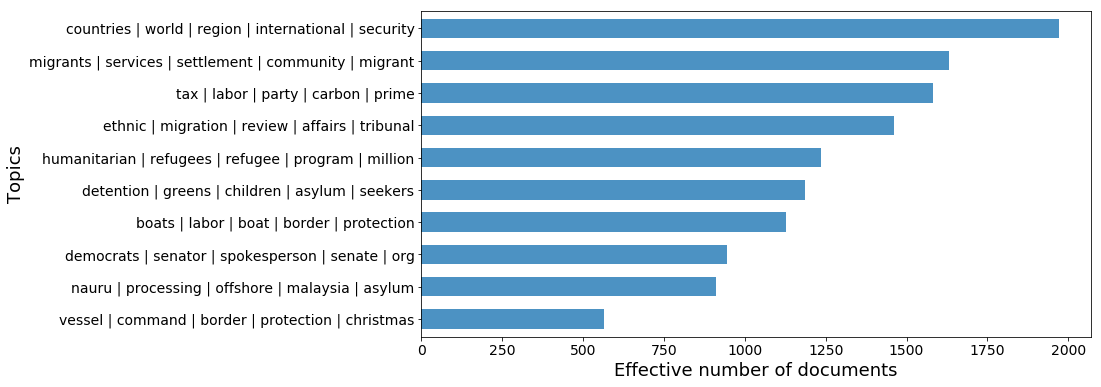

In [33]:
ax = df.sum(axis='rows').sort_values().plot(kind='barh', width=0.6, alpha=0.8, figsize=(12, 6))
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_xlabel('Effective number of documents', fontsize=18)
ax.set_ylabel('Topics', fontsize=18);

As is often the case, the dominant topics are fairly general, because they capture the most basic ideas within the corpus, which are common to many documents (recall that documents don't necessarily belong to a single topic).

## Topic allocation

We can also visualise how a given document is "made up" of different topics. 

Let's illustrate this with the sample press release we used to cleanup the annotations.

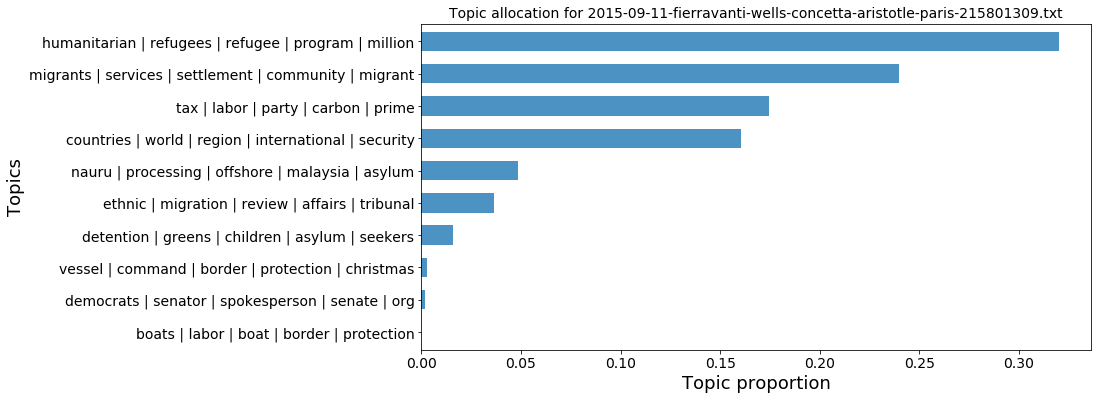

In [34]:
ax = df.iloc[600].sort_values().plot(kind='barh', width=0.6, alpha=0.8, figsize=(12, 6))
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_title(f"Topic allocation for {docs_path[600].name}", fontsize=14)
ax.set_xlabel('Topic proportion', fontsize=18)
ax.set_ylabel('Topics', fontsize=18);

A quick look at the press release shows that this decomposition is reasonable.

This corpus was harvested by looking for refugee/immigration related keywords, so the fact that the majority of
of the topics are about migration/refugee/humanitarian issues makes sense, however, there's a strange topic that seems to be about carbon tax. 

How is this related to refugees? Let's find out.

## Topical archetype

First let's write a helper function to extract the most representative press release(s) for a given topic, and
plot its topic allocation.

In [35]:
def plot_topic_allocation(doc_index):
    fig, ax = plt.subplots(figsize=(8, 3))
    df.iloc[doc_index].sort_values().plot(kind='barh', width=0.6, alpha=0.8, ax=ax)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.set_title(f"Topic allocation for {docs_path[doc_index].name}", fontsize=14)
    ax.set_xlabel('Topic proportion', fontsize=18)
    ax.set_ylabel('Topics', fontsize=18);


def get_most_representative_doc_for_topic(topic, n=3):            
    
    # sort the results according to the score for the topic of interest
    docs_idx = df.iloc[:, topic].sort_values(ascending=False).index.values[:n]
    
    # create a nice header
    label = f'************ {topics[topic].upper()} ************'
    print(f"\n\n{'='*len(label)}\n{label}\n{'='*len(label)}")          
    
    # extract the top n most representative documents          
    results = [docs_path[idx] for idx in docs_idx]    

    # output the results and plot the topic allocations      
    for i, item in zip(docs_idx, results):
        print(item.name)
        plot_topic_allocation(i)
    
    return results

The "carbon tax" topic is topic number 0, let's extract the top 10 press releases.



************ TAX | LABOR | PARTY | CARBON | PRIME ************
2014-11-02-leigh-andrew-211447096.txt
2011-06-14-hunt-greg-211355794.txt
1978-03-05-fraser-malcolm-213722604.txt
2011-06-14-abbott-tony-211355793.txt
2011-07-27-abbott-tony-211358116.txt
2012-07-02-hockey-joe-211376011.txt
2011-07-13-gillard-julia-211357548.txt
2012-07-16-hockey-joe-211428530.txt
2012-07-16-hockey-joe-211428506.txt
2013-03-05-hockey-joe-211391530.txt


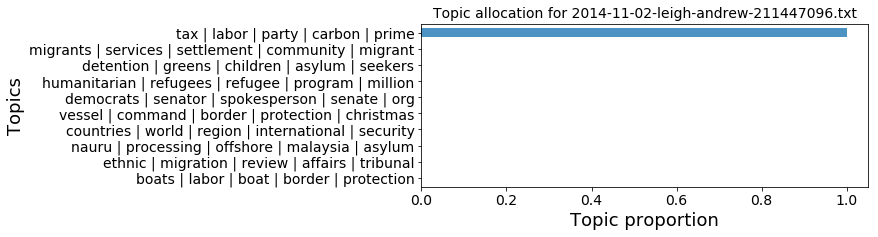

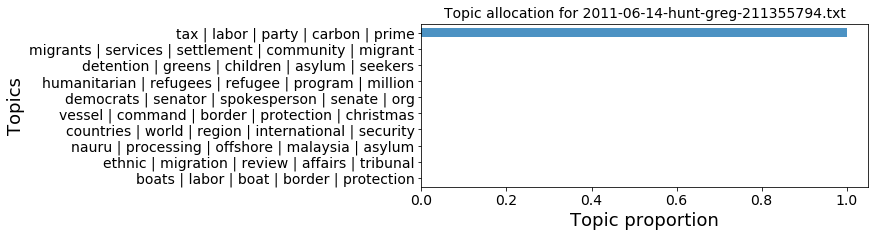

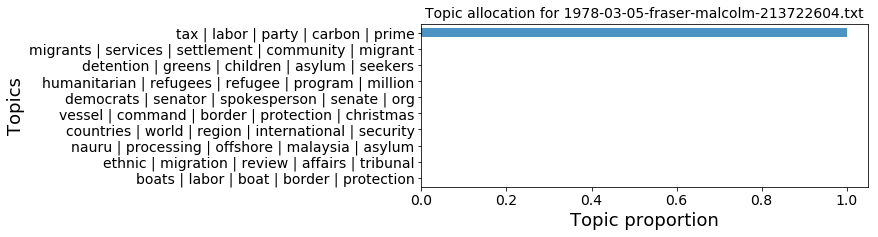

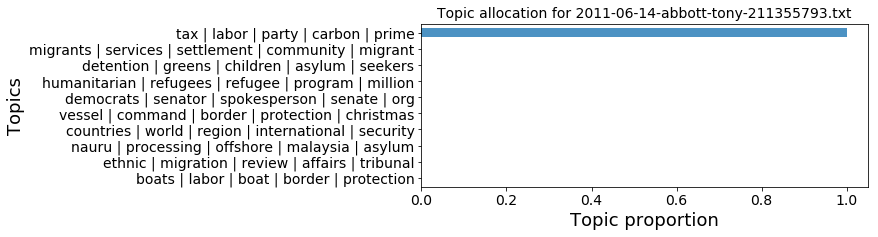

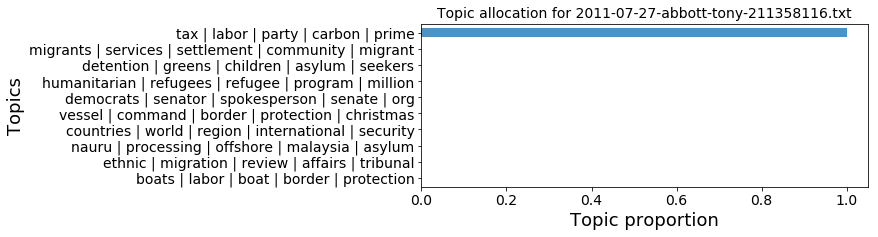

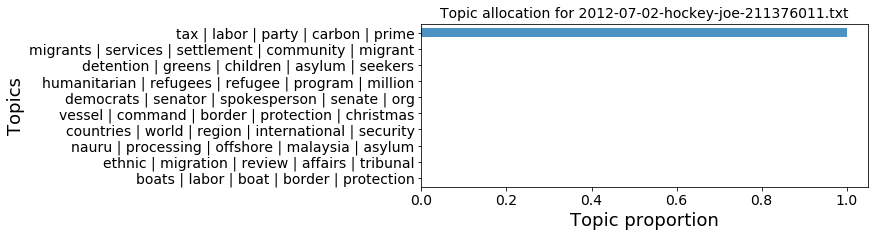

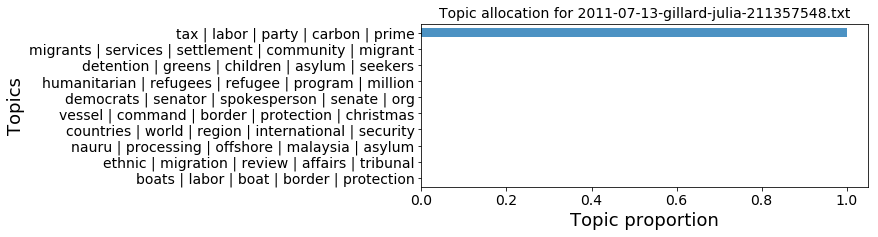

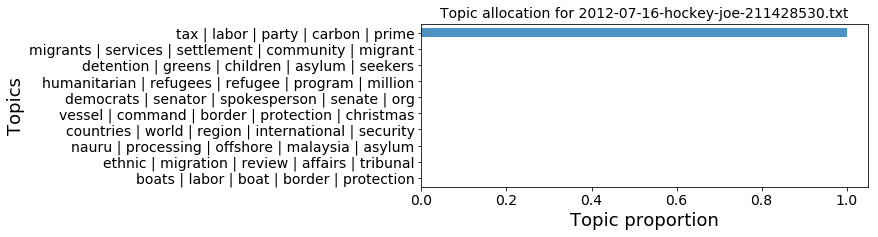

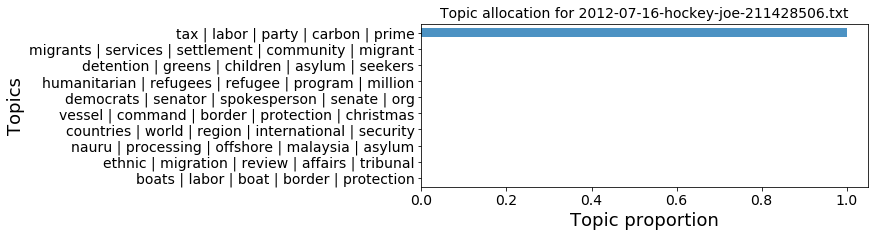

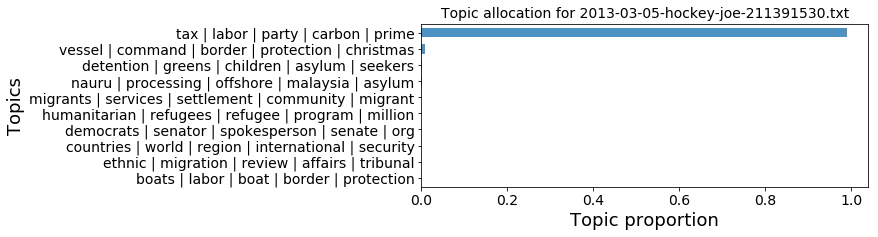

In [36]:
L  = get_most_representative_doc_for_topic(0, n=10)

These documents seem to belong exclusively to the "carbon tax" topic.
Let's look at the first press release.

In [37]:
print(L[0].read_text().strip())

ANDREW LEIGH MP  SHADOW ASSISTANT TREASURER  SHADOW MINISTER FOR COMPETITION  MEMBER FOR FRASER



E&OE TRANSCRIPT  DOORSTOP  SUNDAY, 2 NOVEMBER 2014  CANBERRA, PARLIAMENT HOUSE

SUBJECT/ S: W estern Sydney W anderers; Abbott Government’s broken  promise on GST; Abbott Government’s unfair budget; Climate change.

ANDREW LEIGH, SHADOW ASSISTANT TREASURER: Thanks very much  everyone for coming out today. My name is Andrew Leigh, the Shadow Assistant  Treasurer. I want to open with my congratulations to the Western Sydney  Wanderers, Asian Cup Champions. Just a great result for all Australians and many  hearts will be swelling with pride tonight.

Also wanted to say a few words about the statements that we’ve seen Joe Hockey  and Mathias Cormann making on GST distribution. It would be pretty clear to  anyone who follows the GST debate that if one state is going to get a larger amount  of GST that either means other states get a smaller share of GST or that the rate or

the base of the GST

## A conundrum
This is really not about immigration/refugee issues. So why have these documents been returned when querying immigration-related keywords?

To find how let's create a function to extract only the lines in a press release that match a search pattern.
We'll use the keywords that Tim Sherratt used to harvest the documents as well as a few of our own,  as our search patterns.

In [38]:
def search_for_pattern_in_doc(path, regex):
    text = path.read_text().strip()
    for line in text.splitlines():
        if regex.search(line.lower()) is not None:
            print(f"\n>>>>{line}\n")        

In [39]:
pat = '|'.join(['migrant', 
                'immigration',
                'refugee',
                'asylum',
                'seeker', 
                'boat', 
                'illegal',
                'arrival', 
                'alien'])

regex = re.compile(pat, re.I)

for path in L:
    label = f'************ {path.name.upper()} ************'
    print(f"\n\n{'='*len(label)}\n{label}\n{'='*len(label)}")   
    search_for_pattern_in_doc(path, regex)



************ 2014-11-02-LEIGH-ANDREW-211447096.TXT ************

>>>>JOURNALIST: Mr Leigh on climate change the Environment Minister says that the  Direct Action program will kick off next year. Labor’s position is that Direct Action  won’t work, but you also said that asylum seeker, turning asylum seeker boat  wouldn’t work and that seems to have worked. So is it now time for Labor to allow  this Direct Action policy to run a bit of its course to see if it does work and if it does  work and they get, reach their reduction targets where does that leave the  Opposition?



************ 2011-06-14-HUNT-GREG-211355794.TXT ************

>>>>Mr Abbott, you said over the weekend that Nauru signing up to the UN convention on refugees was  imminent yet according to the United Nations, Nauru hasn’t even made an approach yet to the United  Nations. Just how imminent is it?



************ 1978-03-05-FRASER-MALCOLM-213722604.TXT ************


************ 2011-06-14-ABBOTT-TONY-211355793.TXT *

## Taxation or immigration?

Interesting. Not all these press releases are about immigration/refugee issues, although some of them make brief mentions of related matters. 

I think this might have to do with the nature of the documents.
Some press releases are just that, a statement made by a member of parliament and released to the press.
They tend to be focused on a specific issue around immigration/refugee matters. 

However, some documents (like the one immediately above) are transcripts of Q&A sessions with journalists, which
means that they do not necessarily follow a set agenda. I think this is why some documents tackle many different issues, and might mention immigration matters among a more diverse of topics.

What's particularly surprising though, is that some of the press releases recorded no presence of any of our keywords.
Let's look at one of them more closely.

In [40]:
print(L[2].read_text().strip())

t i Â» W  V  Ã¢ÂÂº Â» w Â«  t> I ÃÂ  ;

ÃÂªÃÂ

FOR PRESS 5 MARCH 1978

ELECTORATE TALK

This year promises significant progress in the Australian  economy.

The results of the Government's firm and responsible economic  management in the last two" years will become even more evident.

It will also be a year when the most dramatic tax cuts in  Australia's history take direct effect throughout the economy. They will lift spending which will, in turn, assist industrial  production and stimulate economic activity. They will help

create jobs.

The Government's economic strategy has been clear. For a long  term and sustained reduction in the number of men. and women  seeking jobs, inflation had to be reduced.

Inflation has been making Australian industry uncompetitive. This 'meant that jobs were lost and opportunities for new jobs  were squandered.

Our success in the fight against inflation is now without  challenge - it is under 10% for the first time since 1972.

Inflation is stil

## Curiouser and curiouser...
I really can't think of why this press release would have been returned in a search query on "refugee/immigration".
Perhaps the press releases were manually curated and some editor assigned them to the wrong category?

In any case, this hopefully illustrates how topic modelling can complement keyword-based queries,
allowing us to gain a deeper insight into a large corpus of documents.

At this stage we could of course explore the other topics in a similar fashion (I encourage you to do so if you're interested), but let's instead take a different look at our corpus.

## A picture is worth 10,000 tokens.

The visualisation of the topics importance in the corpus, displayed above, is nice but it is in some ways too high level. We've aggregated the topics all the way down to a single number (the effective number of documents), thereby losing some of the nuance that is present in the topic model.

An alternate approach consists in trying to visualise both the documents and the topics at the same time.
At the moment (in `X_nmf`) the documents are points in 10-dimensional space (because we have 10 topics). 
That's about 7 or 8 dimensions too many for us to look at, so we need to reduce the dimensionality of our representation, preferably down to 2 dimensions.

There are many ways to project (embed) a collection of points onto a 2D plane. A very common (and computationally cheap) one is principal component analysis, however this method doesn't work well with our type of (nonlinear) data.

An very popular dimensionality reduction technique these days is t-distributed stochastic neighbour embedding (TSNE to its friends). It works well but can be tricky to tune, and computationaly slow at times, which is why I'll use my favourite dimensionality reduction technique to date, the awesome [UMAP](https://umap-learn.readthedocs.io/en/latest/) which stands for 
[Uniform Manifold Approximation and Projection for Dimension Reduction](https://arxiv.org/abs/1802.03426).

I also recommend watching [this wonderful presentation](https://www.youtube.com/watch?v=9iol3Lk6kyU) by [Leland McInnes](https://twitter.com/leland_mcinnes), the creator of the UMAP library. 

The general idea here is to project our 10-dimensional points onto a 2-dimensional plane, in such a way so as to
preserve local similarities. Indeed, if 2 documents are neighbours in the 10-dimensional space, it means that they have similar topic "signatures". What UMAP does is to ensure that these 2 points would also end up close to each other after projection onto a 2-dimensional plane.

We first create an instance of the `UMAP` object, and we then use it to transform `X_nmf` into an array with
still as many rows as we have documents, but only 2 columns. 

In [41]:
%%time
proj = UMAP(n_components=2, n_neighbors=100, min_dist=0.8, random_state=0)
X_proj = proj.fit_transform(X_nmf)

CPU times: user 33.9 s, sys: 2.33 s, total: 36.2 s
Wall time: 29.7 s


Now that we've got a 2-dimensional version of our data, we can plot it as a scatter plot, where each point corresponds to a press release. 

However, we'd also like to have a sense of what each document might be about. 

We can do that by extracting the dominant topic for each document, and using it to colour the point representing the document.

Let's gather all this information in a dataframe

In [42]:
dominant_topic = X_nmf.argsort(axis=1)[:, -1]

In [43]:
df_proj = (pd.DataFrame(X_proj, columns=['x', 'y'])
               .assign(topic_num = dominant_topic)
          )

df_proj = df_proj.assign(topic=df_proj.topic_num.map(topics))

df_proj = pd.concat((df_proj, pd.DataFrame(X_nmf)), axis='columns')

df_proj.head()

,x,y,topic_num,topic,0,1,2,3,4,5,6,7,8,9
0,-0.846373,-4.189077,1,boats | labor | boat | border | protection,0.013513,0.058611,0.000000,0.006378,0.022864,0.000000,0.000669,0.002244,0.005276,0.000000
1,-4.835822,-0.177999,7,humanitarian | refugees | refugee | program | ...,0.000000,0.000000,0.021207,0.000000,0.026870,0.000978,0.000000,0.061928,0.007201,0.000000
2,-5.005290,0.397936,7,humanitarian | refugees | refugee | program | ...,0.003917,0.000682,0.032677,0.011699,0.050171,0.000000,0.000000,0.067918,0.006025,0.000000
3,-0.079695,4.868925,9,migrants | services | settlement | community |...,0.003153,0.000000,0.000000,0.000000,0.004317,0.005031,0.008957,0.000000,0.007589,0.042587
4,-1.882492,-2.729572,3,nauru | processing | offshore | malaysia | asylum,0.015261,0.000000,0.006954,0.053783,0.031058,0.004192,0.011392,0.002010,0.001632,0.000000


For convenience, let's write a function to plot the results, as well as another helper function to zoom in on any  part of the plot (I could have used bokeh to do that interactively, but for simplicity I'll stick with seaborn/matplotlib).

In [44]:
def plot_embedding(df_proj, xlim=None, ylim=None, figsize=(17, 10)):

    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x='x', 
                    y='y', 
                    hue='topic', 
                    data=df_proj, 
                    palette='Paired', 
                    alpha=0.8, 
                    s=50,
                    ax=ax)

    leg = ax.legend(bbox_to_anchor = (1, 1), markerscale=2, frameon=False, prop={"size":14})
    leg.texts[0].set_text("")
    leg.set_title('Dominant topic', prop={"size":18})
    
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
        ax.get_legend().remove()
        
    ax.set_title('Topical portrait of the press releases', fontsize=18)

#     ax.set_axis_off() # comment this line to see the axes
    fig.tight_layout()

    return ax

def list_documents_in_frame(ax):
    indices = df_proj[df_proj.x.between(*ax.get_xlim()) & df_proj.y.between(*ax.get_ylim())].index.values
    return [docs_path[i].name for i in indices]

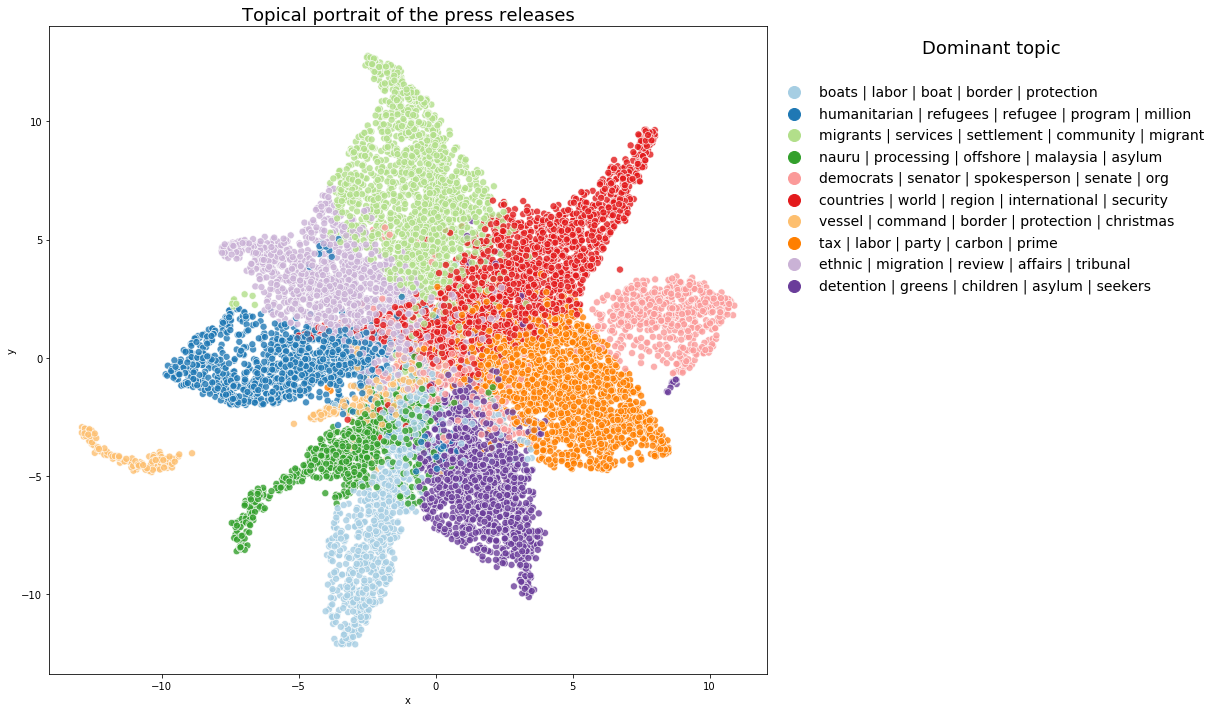

In [45]:
ax = plot_embedding(df_proj)

Each circle represents a press release. The colour corresponds to the _dominant_ topic of each document.

We see that, by and large, the topics form large patches, indicating that our dimensionality reduction technique
has indeed grouped together (topically) similar documents.

Something that isn't obvious in the figure is that points near the boundary between 2 or more "patches" correspond
to documents which are mixtures of topics, whereas points near the extremities of the "tentacles" correspond to documents which belong predominantly to a single topic.

#### Topic similarity

Aside from the fact that this projection groups similar documents together, it also says something about the relationship between the topics (there are better ways to see this but I won't explore them here (I mention some of them [in this notebook](https://nbviewer.jupyter.org/github/adelr/hca-proximity/blob/master/Proximity_and_Neighbourhood.ipynb)).

For instance, the "detention" topic (bottom right, purple colour) is adjacent to the "boat/border protection" topic in light blue, which is adjacent to the "nauru" topic in green. People familiar with the historical background should find this consistent.

Similarly, at the top left we've got 3 similar topics ('humanitarian', 'ethnic', and 'migrants') close to one another (dark blue, light purple, light green). 

On the right-hand side we seem to have more politically oriented topics with the "countries", "democrats", and "tax"
topics. These are harder to understand without delving deeper into the corpus. 


#### Cluster

We also notice an _island_ off the main mass of documents to the left.

Let's zoom in on it.

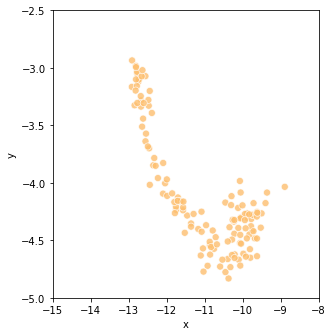

In [46]:
ax = plot_embedding(df_proj, xlim=[-15, -8], ylim=[-5, -2.5], figsize=(5, 5))
ax.set_title(None);

We can use this zoomed-in version to extract a list of the cases corresponding to the points in the frame of the figure.

In [47]:
docs = list_documents_in_frame(ax)

In [48]:
print(docs)

['2010-04-06-o-connor-brendan-australian-labor-party-211336677.txt', '2009-12-29-o-connor-brendan-australian-labor-party-211332844.txt', '2011-11-22-o-connor-brendan-211364476.txt', '2011-05-16-o-connor-brendan-211352983.txt', '2010-04-11-o-connor-brendan-australian-labor-party-211336889.txt', '2010-07-29-o-connor-brendan-australian-labor-party-211342205.txt', '2010-04-02-o-connor-brendan-australian-labor-party-211336615.txt', '2010-03-14-o-connor-brendan-australian-labor-party-211335718.txt', '2010-02-24-o-connor-brendan-australian-labor-party-211334655.txt', '2010-08-28-o-connor-brendan-211343503.txt', '2010-09-29-o-connor-brendan-211344079.txt', '2010-10-01-o-connor-brendan-211344217.txt', '2010-09-02-o-connor-brendan-211343532.txt', '2011-08-12-o-connor-brendan-211358814.txt', '2011-11-14-o-connor-brendan-211363975.txt', '2010-08-22-o-connor-brendan-australian-labor-party-211343437.txt', '2010-10-09-o-connor-brendan-211344490.txt', '2010-03-22-o-connor-brendan-australian-labor-part

Judging by the names of the files, these releases should be fairly similar (they all share the same dominant topic anyway).

Let's look at a couple of them.

In [49]:
print((Path('texts')/docs[0]).read_text().strip())

VESSEL INTERCEPTED BY BORDER PROTECTION COMMAND

6 April 2010

HMAS Childers operating under the control of Border Protection Command successfully  intercepted a suspected irregular entry vessel last night, near West Island at Ashmore Reef.

Initial indications suggest 22 passengers and one crew member are on board the vessel.

The Australian Government remains committed to protecting the Australian border from  maritime threats, including people smuggling. People smuggling is a global and regional  problem and the Australian Government continues to work closely with our regional  neighbours to address this issue.

People smugglers seek out and exploit vulnerable persons who, having faced uncertainty,  conflict and violence, pursue stability and safety.

The Australian Government has committed more than $654 million to implement a  comprehensive people smuggling strategy to combat this issue with an expanded presence in  the region by the Australian Federal Police, the Department of Fo

In [50]:
print((Path('texts')/docs[10]).read_text().strip())

Brendan O’Connor, MP  Minister for Home Affairs  Minister for Justice  Minister for Privacy and Freedom of Information

Member for Gorton

Wednesday, 29 September 2010

Border Protection Command intercepts vessel



HMAS Ararat, operating under the control of Border Protection Command, intercepted a suspected  irregular entry vessel north of Ashmore Islands this afternoon.



Initial indications suggest there are 18 passengers and two crew on board.



The group will be transferred to Christmas Island where they will undergo security, identity and  health checks and their reasons for travel will be established.



Media Adviser: Jayne Stinson 0458 547 512 jayne.stinson@ag.gov.au


In [51]:
print((Path('texts')/docs[20]).read_text().strip())

UNCLASSIFIED







ATTORNEY-GENERAL   HON ROBERT McCLELLAND MP

BORDER PROTECTION COMMAND INTERCEPTS  VESSEL



[4 January 2010] Border Protection Command yesterday successfully intercepted a suspected  irregular entry vessel.

HMAS Albany, operating under the control of Border Protection Command, intercepted the  vessel at 6.20pm (AEDST) on 3 January 2010 approximately 29 nautical miles south of  Cartier Island.

Initial indications suggest 30 passengers and 2 crew are on board the vessel.

Situations around the world mean that large numbers of displaced persons are looking for  settlement and can be targeted by, and fall prey to, people smugglers.

According to the UNHCR 2008 Global Trends report, there were 42 million forcibly  displaced persons worldwide at the end of 2008, including 15.2 million refugees.

People smuggling is not just an issue for Australia - it is a global and regional problem. The  commitment of our neighbours, through bilateral cooperation and the Bali Process

----
These seem to be highly specific to vessel interception, which explains the tight cluster. Of course, one should take a closer look at the rest of the documents in this cluster before drawing any conclusion.

One stricking thing with the 3 examples above is  that some of these press releases are very short, which makes me think that we should look at the distribution of length among the press releases.

## How brief are the briefs?

Let's create a pandas series with the length (number of characters including white spaces) of the press releases.

In [52]:
doc_length = pd.Series((len(p.read_text().strip()) for p in docs_path))

Do any of the documents contain no text?

In [53]:
(doc_length == 0).sum()

2

We've got two empty press releases!

In [54]:
for idx in doc_length[doc_length == 0].index:
    print(docs_path[idx].name)
    print(docs_path[idx].read_text())

2001-12-07-ruddock-philip-liberal-party-of-australia-211232311.txt





1994-06-15-bilney-gordon-211185291.txt

































---- 
Rather light on content, _even for a political press release_...

Let's visualise the overal distribution of press release lengths in our corpus.

## Length distribution

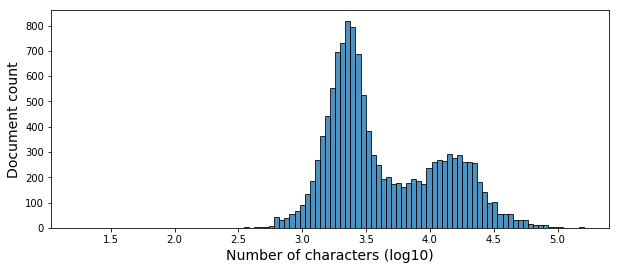

In [55]:
ax = np.log10(doc_length[doc_length > 0]).hist(bins=100, 
                                               ec='k', 
                                               grid=False, 
                                               alpha=0.8, 
                                               figsize=(10, 4))

ax.set_xlabel('Number of characters (log10)', fontsize=14)
ax.set_ylabel('Document count', fontsize=14);

Interesting. We've got a bimodal distribution, with lots of short(ish) press releases around 2,500 characters long (~ 10 ** 3.4), and a whole bunch of longer documents with around 20,000 characters long (~ 10 ** 4.4).

We can use `doc_length` to compute the proportion of documents that are longer than some threshold.

For instance, if we eyeball the central dip of the distribution at around 3.75 (for the log), this gives us a threshold around 5,600 characters long. 

Let's compute the associated proportion of documents in the corpus:

In [56]:
(doc_length <= 10**3.75).mean()

0.642206197004517

So we've got about 64% of the press releases which are on the short(ish) side... 

## Is length correlated with topic?

I'm now curious about whether the two types of lengths correspond to different topics (that's the problem with exploratory data analysis, there's always a new rabbit hole to explore).

Let's create a mask to select the shorter documents and plot the topic importance just for that subset.

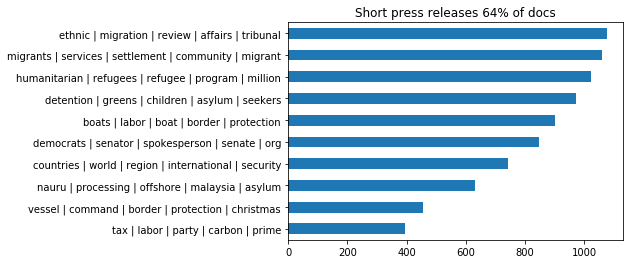

In [57]:
mask = doc_length <= 10**3.75

ax = df[mask].sum(axis='rows').sort_values().plot(kind='barh')
ax.set_title(f'Short press releases {mask.mean()*100:.0f}% of docs');

Let's do the same with the longer documents.

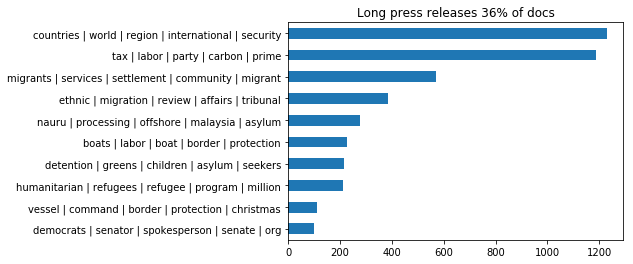

In [58]:
ax = df[~mask].sum(axis='rows').sort_values().plot(kind='barh')
ax.set_title(f'Long press releases {(~mask).mean()*100:.0f}% of docs');

Let's look at the really short documents, with less than 2,000 characters.

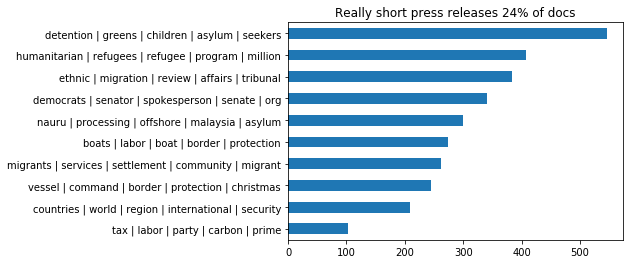

In [59]:
mask = doc_length <= 2000

ax = df[mask].sum(axis='rows').sort_values().plot(kind='barh')
ax.set_title(f'Really short press releases {mask.mean()*100:.0f}% of docs');

I find the fact that the `ethnic | migration | review | affairs | tribunal` topic dominates the lower end of the corpus quite interesting. 

It's also striking that the `detention` topic relates to the shortest of the press releases. 

Let's examine both.


#### ETHNIC | MIGRATION | REVIEW | AFFAIRS | TRIBUNAL

Let's extract 3 representative documents



************ ETHNIC | MIGRATION | REVIEW | AFFAIRS | TRIBUNAL ************
1993-02-04-hand-gerry-211180105.txt
1997-07-13-williams-daryl-211455173.txt
2015-07-01-brandis-george-212594208.txt


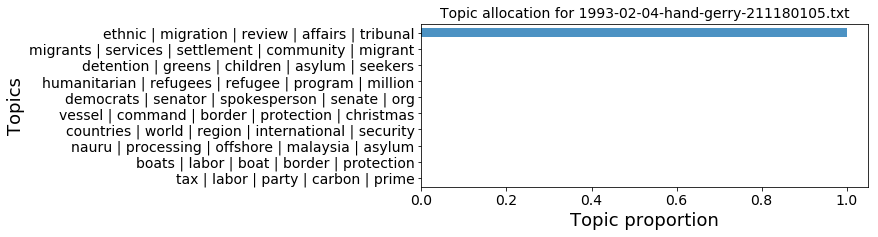

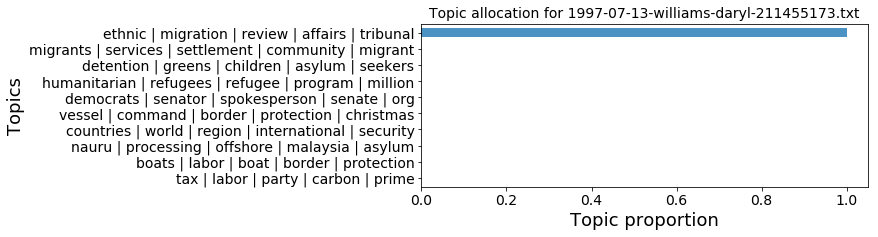

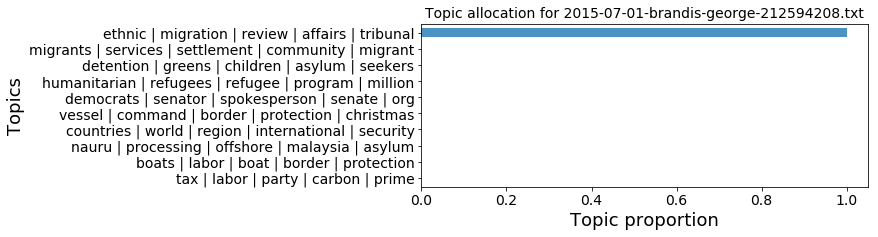

In [60]:
L  = get_most_representative_doc_for_topic(2, n=3)

##### Document 1

In [61]:
print(L[0].read_text().strip())

Media Release

Minister for Immigration, Local Government and Ethnic Affairs The Hon. Gerry Hand, MPParliament House, Canberra, ACT 2600Telephone: (06) 277 7860MPS 6/93IMMIGRATION MINISTER ANNOUNCES APPOINTMENTS TO REFUGEE REVIEW TRIBUNALThe Minister for Immigration, Local Government and Ethnic Affairs, Mr Gerry Hand, today announced the appointment of the Principal Member and a Member to the Refugee Review Tribunal (RRT).Mr Hand said the Principal Member would be Professor Leroy Certoma of Sydney, and the first Member appointed would be Mr Maurice William Gerkens of Melbourne. hProfessor Certoma was previously the Senior Member of the Immigration Review Tribunal in NSW. He is currently a Visiting Professor, Faculty of Law, University of NSW, and Professorial Fellow, Faculty of Law, University of Wollongong.Mr Gerkens has been a Victorian magistrate for 16 years. He has also held positions with the Metropolitan Fire Brigades Tribunal and the Country Fire Authority Appeal Tribunal.Mr Ha

##### Document 2

In [62]:
print(L[1].read_text().strip())

Cabinet has reaffirmed its decision to streamline the present merits review
system through amalgamation of a number of existing tribunals into an
independent Administrative Review Tribunal.

As Cabinet decided
in March, the Administrative Appeals Tribunal, the Social Security Appeals
Tribunal, the Immigration Review Tribunal, the Refugee Review Tribunal and
the Veterans Review Board would be amalgamated to form a new Administrative
Review Tribunal.

That in-principle decision followed
consideration of the Better Decisions report from the Administrative Review
Council which recommended amalgamation.

An Inter-Departmental
Committee was established to devise a strategy for implementation of the
decision. The committee will report to Cabinet in due course.

The Cabinet is firm in its resolve that any proposal for reform of the
merits review tribunals is not to affect the level of independence of such
bodies in reaching decisions and it is confident that the report of the
interdepartmental

##### Document 3

In [63]:
print(L[2].read_text().strip())

SENATOR THE HON GEORGE BRANDIS QC  ATTORNEY-GENERAL  MINISTER FOR THE ARTS

MEDIA RELEASE

MILESTONE AMALGAMATION OF KEY COMMONWEALTH   MERITS REVIEW TRIBUNALS

Today, I attended a ceremonial sitting of the Administrative Appeals Tribunal to welcome the  most significant reform to Commonwealth administrative law in 40 years; the amalgamation  of the Administrative Appeals Tribunal, the Social Security Appeals Tribunal and the  Migration Review Tribunal Refugee Review Tribunal into a single body, the Administrative  Appeals Tribunal.

The Administrative Appeals Tribunal will provide an accessible, efficient and informal  process for review of government decisions.

The ceremonial sitting was attended by key figures in the history of the Administrative  Appeals Tribunal, including the current President, the Honourable Justice Duncan Kerr Chev  LH, Sir Gerard Brennan KBE QC and the Honourable Robert Ellicott QC.

The amalgamation will strengthen the efficacy of Commonwealth merits review 

#### A mostly judicial/jurisdictional topic it seems...
These are mostly about jurisdictional changes around tribunal amalgamation, including the tribunals historically competent in migration and refugee matters.    

This helps explain the short nature of these press release (of course, in an in-depth study we'd check this hypothesis more thoroughly).

#### DETENTION | GREENS | CHILDREN | ASYLUM | SEEKERS

Once again, let's extract 3 representative documents.



************ DETENTION | GREENS | CHILDREN | ASYLUM | SEEKERS ************
2012-05-23-hanson-young-sarah-211373692.txt
2014-09-09-hanson-young-sarah-211413722.txt
2012-05-22-hanson-young-sarah-211373582.txt


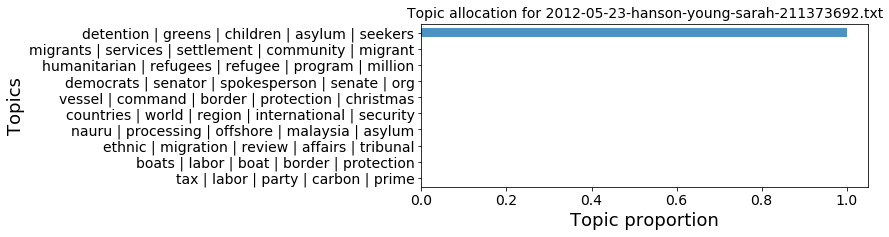

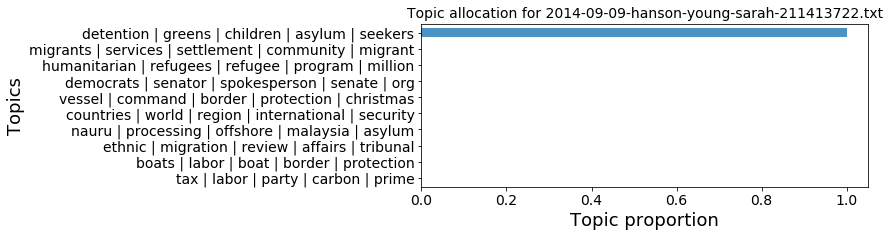

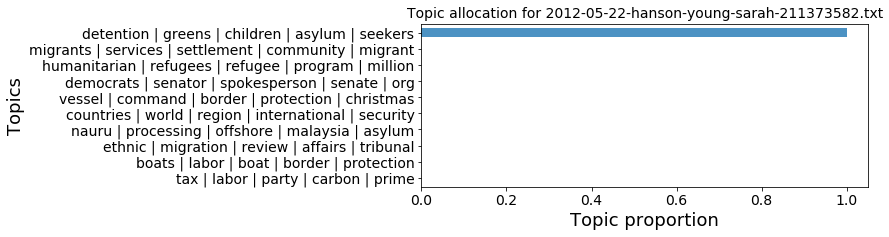

In [64]:
L  = get_most_representative_doc_for_topic(8, n=3)

##### Document 1

In [65]:
print(L[0].read_text().strip())

New ‘asylum seeker syndrome’ is avoidable with time  limits on detention: Greens    A new psychological condition diagnosed among asylum seekers held in indefinite detention is  further evidence of the need to put timeÃ¢ÂÂlimits on detention and close remote and isolated  detention centres, the Australian Greens said today.    "The discovery of this new mental illness syndrome is nothing for Australia to be proud of," Greens'  immigration spokesperson, Sen. Sarah HansonÃ¢ÂÂYoung, said.    "It is saddening to learn that this new condition is being created because of the longÃ¢ÂÂterm and  indefinite detention of vulnerable people who have sought Australia's protection but instead are  being even further harmed and damaged.    “The recent Parliamentary Inquiry into Australia’s Detention Network saw significant evidence of the  mental health crisis that that exists in our detention centres.         "The committee's final report found 86 percent of all detained asylum seekers displaye

##### Document 2

In [66]:
print(L[1].read_text().strip())

MEDIA RELEASE

Tuesday, 9 September 2014

Immigration Minister not fit to be children’s  guardian

Following evidence given to the Human Rights Commission inquiry into children in detention  today, the Australian Greens have called on all parties to support a bill that would see the  Immigration Minister stripped of the guardianship of unaccompanied refugee children.

“The Minister is clearly incapable of acting in these children’s best interests,” the Greens’  immigration spokesperson, Senator Sarah Hanson-Young said.

“The Greens’ bill, which has been introduced into the Senate, would see the guardianship of  unaccompanied children taken from the Minister and given to an independent office.

“Minister Morrison and Minister Bowen have both failed to act in the best interest of children  that they have been guardian to.

“It’s hard to imagine anything more terrifying for a young, unaccompanied girl than being sent  to the hellhole on Nauru.

“Scott Morrison is these children’s jailer, 

##### Document 3

In [67]:
print(L[2].read_text().strip())

Tuesday, 22 May 2012    MEDIA RELEASE

New ‘asylum seeker syndrome’ is avoidable with time  limits on detention: Greens    A new psychological condition diagnosed among asylum seekers held in indefinite detention is  further evidence of the need to put timeÃ¢ÂÂlimits on detention and close remote and isolated  detention centres, the Australian Greens said today.    "The discovery of this new mental illness syndrome is nothing for Australia to be proud of," Greens'  immigration spokesperson, Sen. Sarah HansonÃ¢ÂÂYoung, said.    "It is saddening to learn that this new condition is being created because of the longÃ¢ÂÂterm and  indefinite detention of vulnerable people who have sought Australia's protection but instead are  being even further harmed and damaged.    “The recent Parliamentary Inquiry into Australia’s Detention Network saw significant evidence of the  mental health crisis that that exists in our detention centres.         "The committee's final report found 86 percent 

----
Aside from the fact that we've got the same press release twice a day apart, these seem to all be short statements
from the Green's senator about overseas detention of asylum seekers, particularly children. We must keep in mind, of course, the previous caveat about making sweeping statements from 3 (ok actually 2) documents...

## Mapping document length

We can actually use our 2D projection to visualise how document lengths are distributed across the corpus.

To this end, it would be helpful to know how long the longest press release is.

In [68]:
doc_length.max()

160306

That a mighty long press release! Let's check it out (Rabbit holes! It's all rabbit holes!).

In [69]:
print(docs_path[doc_length.idxmax()].read_text().strip()[:5000])

SENATOR MICHAELIA CASH

Shadow Parliamentary Secretary for Immigration

SENATOR GARY HUMPHRIES

Chair - Senate Legal & Constitutional Affairs References Committee

***MEDIA RELEASE***

SENATE COMMITTEE ISSUES DAMNING  REPORT ON MALAYSIA SOLUTION

The Senate Legal & Constitutional Affairs Committee has today tabled the damning  report of its inquiry into the Government’s troubled Malaysia Solution.

“The Committee’s report tells us what most Australians already know - the Malaysia  Solution is terrible public policy,” Shadow Parliamentary Secretary for Immigration,  Senator Michaelia Cash, said today.

“The Malaysia Solution has been shown to have been cobbled together with little  attention to detail and absolutely no due diligence.  The process has been a shambles.

“The Committee’s report merely strengthens the case that the Government must dump  this atrocious non-solution to boat arrivals.

“The Malaysia Solution has received a categorical rejection from the Senate Legal &  Constit

##### The press release contains a copy of the Senate report on the Malaysia Solution policy. 

This explains the length. Now, back on track.

First let's create a copy of `df_proj` and call it `tmp` (naming things is, after all, one of the hardests things in computer science) and add a `length` feature, which we'll bin into 5 intervals, making sure we include the longest press release.

In [70]:
tmp = df_proj.copy() 
tmp['length'] = pd.cut(doc_length, [0, 2000,  5000, 20000, 50000, 200000])
tmp.head()

,x,y,topic_num,topic,0,1,2,3,4,5,6,7,8,9,length
0,-0.846373,-4.189077,1,boats | labor | boat | border | protection,0.013513,0.058611,0.000000,0.006378,0.022864,0.000000,0.000669,0.002244,0.005276,0.000000,"(2000, 5000]"
1,-4.835822,-0.177999,7,humanitarian | refugees | refugee | program | ...,0.000000,0.000000,0.021207,0.000000,0.026870,0.000978,0.000000,0.061928,0.007201,0.000000,"(2000, 5000]"
2,-5.005290,0.397936,7,humanitarian | refugees | refugee | program | ...,0.003917,0.000682,0.032677,0.011699,0.050171,0.000000,0.000000,0.067918,0.006025,0.000000,"(5000, 20000]"
3,-0.079695,4.868925,9,migrants | services | settlement | community |...,0.003153,0.000000,0.000000,0.000000,0.004317,0.005031,0.008957,0.000000,0.007589,0.042587,"(2000, 5000]"
4,-1.882492,-2.729572,3,nauru | processing | offshore | malaysia | asylum,0.015261,0.000000,0.006954,0.053783,0.031058,0.004192,0.011392,0.002010,0.001632,0.000000,"(5000, 20000]"


#### Let's plot the results.

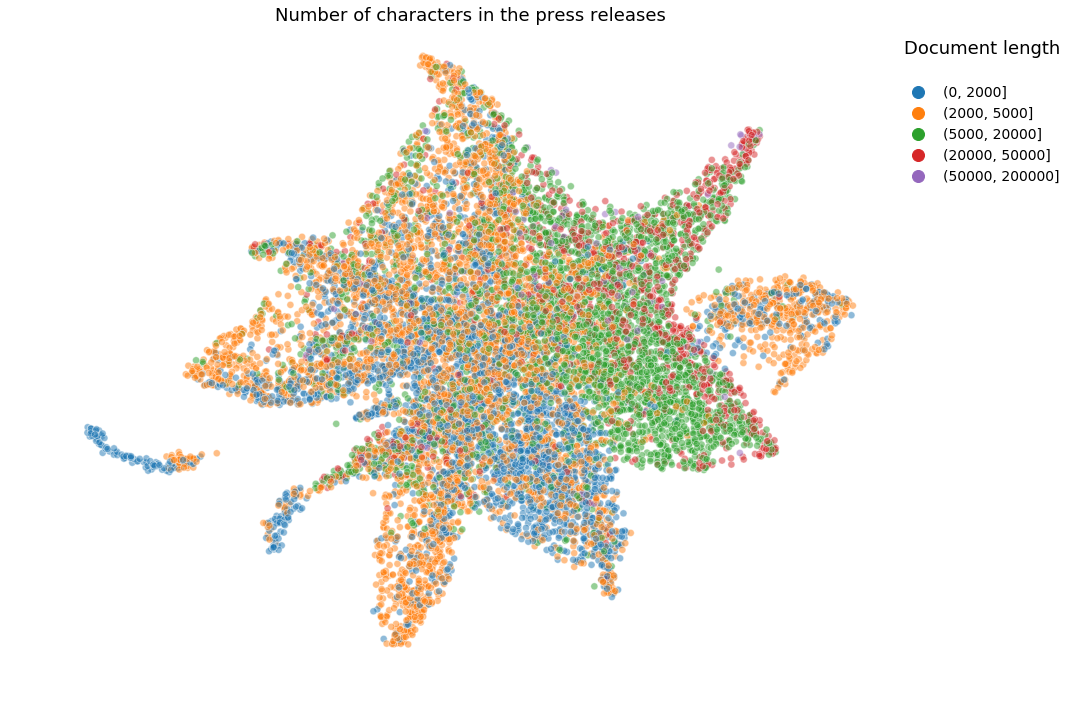

In [71]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x='x', 
                y='y', 
                hue='length', 
                data=tmp, 
                palette='tab10', 
                alpha=0.5, 
                s=50,
                ax=ax)

leg = ax.legend(bbox_to_anchor = (1, 1), 
                markerscale=2, 
                frameon=False, 
                prop={"size":14})

leg.texts[0].set_text("")
leg.set_title('Document length', prop={"size":18})

ax.set_title('Number of characters in the press releases', fontsize=18)

ax.set_axis_off() # comment this line to see the axes
fig.tight_layout()

It a bit of Pollockian mess, but there's clearly a bias toward longer press releases in the "tax" and "countries" topics, as we inferred previously from our previous analysis. My hypothesis is that these topics (and by extension the concomitant documents) are less about immigration and more about economic/diplomatic/fiscal policies, topics which, it appears, politicians are more willing to discuss at great length than immigration/refugee issues...

We could of course dig deeper, but I'd like to look at one dimension I've hitherto ignored. __Time__.

## Topics in time

Our topic analysis has so far looked at the corpus as a whole. In particular, at the moment we cannot really say anything about time evolution and other chronological trends about the data.

We need to extract a date for each press release. We could try to extract the dates from the text of the releases ("I know, I'll use regular expressions!"), however, Tim Sherratt has done the hard work for us, and the date is part of the name of each file.

In [72]:
[p.name for p in docs_path[:10]]

['2009-10-15-truss-warren-national-party-of-australia-211330210.txt',
 '1975-04-02-whitlam-gough-213696538.txt',
 '1989-06-13-evans-gareth-214060412.txt',
 '2002-10-20-patterson-kay-liberal-party-of-australia-211249016.txt',
 '2012-06-27-carr-bob-211375704.txt',
 '1967-09-05-snedden-billy-211169526.txt',
 '2006-10-03-hawke-bob-211298912.txt',
 '2012-10-03-plibersek-tanya-211382938.txt',
 '2001-03-25-ellison-chris-liberal-party-of-australia-211222120.txt',
 '1977-01-09-whitlam-gough-213829369.txt']

No need for a regex here, good old slicing will do just fine.

In [73]:
[p.name[:10] for p in docs_path[:10]]

['2009-10-15',
 '1975-04-02',
 '1989-06-13',
 '2002-10-20',
 '2012-06-27',
 '1967-09-05',
 '2006-10-03',
 '2012-10-03',
 '2001-03-25',
 '1977-01-09']

This plus pandas will solve our problem.

In [74]:
pd.to_datetime([p.name[:10] for p in docs_path[:10]])

DatetimeIndex(['2009-10-15', '1975-04-02', '1989-06-13', '2002-10-20',
               '2012-06-27', '1967-09-05', '2006-10-03', '2012-10-03',
               '2001-03-25', '1977-01-09'],
              dtype='datetime64[ns]', freq=None)

Let's take the jump and do it for the whole data set.

In [75]:
dates = pd.to_datetime([p.name[:10] for p in docs_path])

df_proj_with_dates = (df_proj
                      .assign(date=dates)
                      .set_index('date')
                      .sort_index()
                     )

In [76]:
df_proj_with_dates.head()

,x,y,topic_num,topic,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,,,,,
1950-08-01,4.329054,3.123450,4,countries | world | region | international | s...,0.023937,0.000000,0.006266,0.0,0.061413,0.0,0.000000,0.00051,0.000000,0.000000
1955-03-16,3.618254,2.517195,4,countries | world | region | international | s...,0.020160,0.000000,0.004942,0.0,0.050796,0.0,0.000000,0.00000,0.002641,0.000000
1959-02-12,-0.484830,4.863503,9,migrants | services | settlement | community |...,0.001695,0.000000,0.008350,0.0,0.006976,0.0,0.000000,0.00000,0.000000,0.041208
1959-02-19,-1.152938,1.115070,2,ethnic | migration | review | affairs | tribunal,0.000000,0.002656,0.017497,0.0,0.008170,0.0,0.002819,0.00000,0.000000,0.000000
1959-02-20,-1.646153,4.221575,9,migrants | services | settlement | community |...,0.001292,0.000000,0.028476,0.0,0.004393,0.0,0.000000,0.00000,0.000000,0.035629


### Number of press releases per year

(Keep in mind that this data is a subset of the press releases)

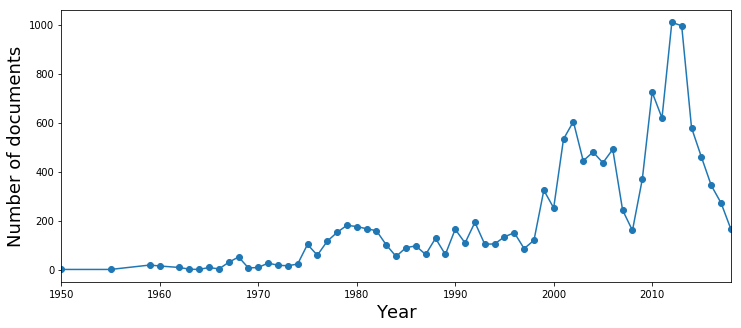

In [77]:
ax = (df_proj_with_dates
     .groupby(df_proj_with_dates.index.year)
     .size()
     .plot(figsize=(12, 5), marker='o')
     )
ax.set_ylabel('Number of documents', fontsize=18)
ax.set_xlabel('Year', fontsize=18);

### Topic timelines

Let's break the time series down into topics by computing the effective number of documents per topic, as we did earlier, but for each year.

To make things more visible, let's plot each topic trend on its own.

/Users/arahmani/anaconda/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  from ipykernel import kernelapp as app


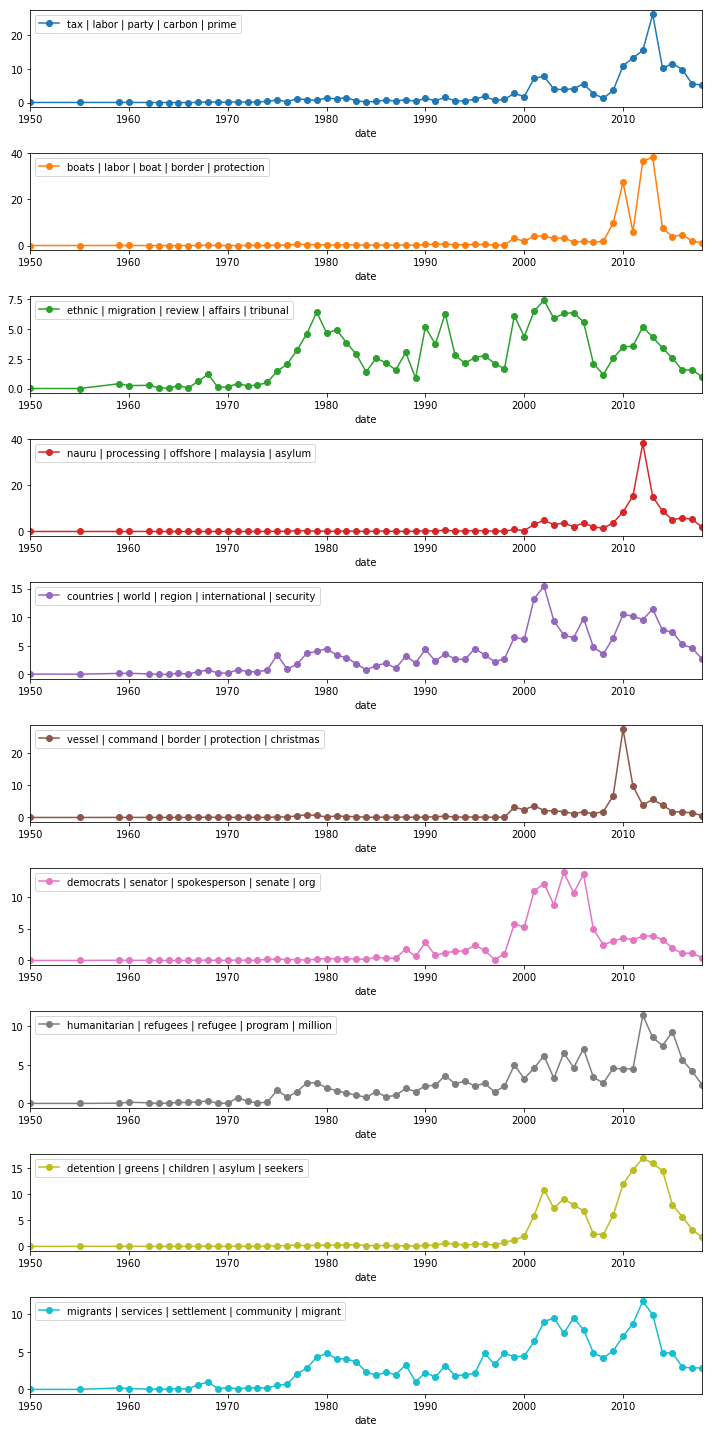

In [78]:
axes = (df_proj_with_dates
        .rename_axis(topics, axis=1)
        .iloc[:, -10:] 
        .groupby(df_proj_with_dates.index.year)
        .sum(axis='rows')
        .plot(figsize=(10, 20), 
              marker='o', 
              subplots=True, 
              sharex=False)
       )
plt.tight_layout()

There are some very interesting trends here. Some are fairly easy to understand if you are familiar with the history of Australia's immigration policy. The [Nauru regional processing centre](https://en.wikipedia.org/wiki/Nauru_Regional_Processing_Centre), for instance, was first opened in 2001, suspended in 2008, before reopening in 2012. This explains the peak observed for the 'nauru' topic in 2012.
It also explains some of the features around 2012 in the other topics (the topics aren't necessarily mutually exclusive or independent).



# Conclusion

This turned out to be a very interesting, and sometimes surprising data set. There's so much more to investigate in this data, and I might do just that in the future. 

The purpose of this analysis was to explore the data, and build a basic pipeline to allow us
to perform a variety of analyses. It's a starting point, not a finished work. 
Of course, most of the principles and techniques used in this notebook are not restricted to this data set.
You might also find them useful for other similar projects. If you do, I'd love to hear about it.

Finally, none of this analysis would have been possible without the data, I am therefore very grateful to [Tim Sherratt](https://twitter.com/wragge) for making these documents so easily accessible, and I encourage 
you to explore his wonderful work over at the [GLAM Workbench website](https://glam-workbench.github.io/).

----
Copyright &copy; 2019 <a href="https://twitter.com/dinkumdata">Adel Rahmani</a>. 

The text is released under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>, and the code is released under the <a href="https://opensource.org/licenses/MIT">MIT license</a>.